# Imports

In [631]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.optimizers import Adam
from keras.metrics import Precision
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Leitura do dataset

In [632]:
df = pd.read_csv('/content/processado_base_ml_bolsa.csv', sep=';')
df.head()

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
0,10.00002,7.581705,7.5,8.816667,5.625000,7.916665,5.0,7.675509,1
1,10.00002,8.071429,7.5,5.083333,6.250000,8.055553,5.0,7.117065,0
2,6.41668,8.557505,7.5,7.083333,6.458333,7.833337,5.0,7.232336,0
3,9.00002,9.333333,7.5,5.500000,6.250000,7.500000,10.0,7.741669,0
4,10.00002,9.314954,7.5,5.583333,5.937500,7.916670,5.0,7.406743,0


In [633]:
# executa um embaralhamento inicial, para garantir a aleatoriedade da amostra
df = shuffle(df, random_state=777)

# arredonda os indicadores
df = df.round(2)

In [634]:
df.head()

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
414,7.42,7.46,5.0,4.93,5.62,6.50,5.0,6.08,0
232,8.75,6.77,7.5,4.67,7.19,7.37,5.0,6.61,1
282,8.00,7.75,7.5,5.75,6.04,7.50,5.0,6.85,0
511,7.00,8.24,7.5,3.67,6.25,6.83,5.0,6.32,0
643,9.50,8.09,7.5,2.00,6.46,6.61,10.0,6.69,0


In [635]:
set(df['INDICADO_BOLSA'])

{0, 1}

In [636]:
df['INDICADO_BOLSA'].value_counts()

INDICADO_BOLSA
0    730
1    132
Name: count, dtype: int64

# Melhorando os dados de treino
Nesta seção, adicionamos alguns dados mockados para incrementar o dataset de alunos.
*   200 registros de alunos com notas >= 8 nos indicadores, que representam ótimos candidatos à indicação de bolsa
*   100 registros de alunos notas >= 0 e <= 5 nos indicadores, que indicam que são alunos que não deveriam receber uma indicação de bolsa

Tais dados mockados têm o intuíto de incrementar os dados de treino para melhorar a performance da rede neural.

In [637]:
colunas = df.columns.difference(['INDICADO_BOLSA'])

In [638]:
mock_alunos1 = np.random.uniform(8, 10, size=(200, len(colunas)))
mock_alunos1 = pd.DataFrame(mock_alunos1, columns=colunas)
mock_alunos1['INDICADO_BOLSA'] = 1
mock_alunos1

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,8.497028,9.170677,9.555564,9.660329,9.894802,9.509675,9.992188,8.640020,1
1,8.113665,8.047661,9.545935,8.525515,9.316980,9.127309,8.162232,9.477111,1
2,9.542084,8.015168,9.689666,8.437359,8.940179,8.512998,8.435443,8.115162,1
3,8.617537,8.291022,9.227077,8.372605,8.960303,8.020489,9.550809,8.473603,1
4,8.593871,9.112211,8.354248,9.892729,9.627584,8.892272,8.745931,9.769614,1
...,...,...,...,...,...,...,...,...,...
195,9.876912,8.017631,8.238795,8.900031,9.806883,8.200672,8.106795,9.891776,1
196,9.745504,9.289234,8.216917,8.825928,8.793401,9.623701,9.539024,8.588217,1
197,9.367559,8.581051,9.497647,9.579906,8.358541,8.495337,9.749900,8.204776,1
198,8.712724,8.973764,9.520889,9.325239,8.986783,8.676439,8.468944,9.826228,1


In [639]:
mock_alunos2 = np.random.uniform(0, 5, size=(400, len(colunas)))
mock_alunos2 = pd.DataFrame(mock_alunos2, columns=colunas)
mock_alunos2['INDICADO_BOLSA'] = 0
mock_alunos2

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,2.278535,1.346994,1.285417,4.519278,1.158763,2.277816,1.504981,4.796669,0
1,0.641146,1.103898,2.553926,1.099977,4.930368,1.488877,0.607941,0.223739,0
2,4.847022,2.209901,1.828829,0.140455,4.346187,4.144279,0.915821,3.692421,0
3,0.563789,1.897305,3.901427,4.823127,3.352844,0.435249,1.047447,4.980089,0
4,0.178856,4.601541,0.400739,0.022992,2.097005,1.870098,3.325125,3.089514,0
...,...,...,...,...,...,...,...,...,...
395,3.125172,3.086563,3.730090,3.602245,1.987519,2.364690,3.853671,3.084992,0
396,2.101187,3.925298,2.723187,4.501397,1.622178,2.803849,0.062423,0.060790,0
397,4.124479,0.609747,3.768403,3.677353,4.388236,1.303573,1.267966,1.024952,0
398,2.876806,3.219132,3.499476,3.082254,0.905612,3.971930,2.546016,1.651836,0


In [640]:
df = pd.concat([df, mock_alunos1, mock_alunos2, mock_alunos3], ignore_index=True)

# Preparando o dataset para ML

In [641]:
# features
X = df[df.columns.difference(['INDICADO_BOLSA'])]
# targets
y = df['INDICADO_BOLSA']

In [642]:
X

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV
0,7.420000,5.000000,4.930000,7.460000,6.080000,5.620000,5.000000,6.500000
1,8.750000,5.000000,4.670000,6.770000,6.610000,7.190000,7.500000,7.370000
2,8.000000,5.000000,5.750000,7.750000,6.850000,6.040000,7.500000,7.500000
3,7.000000,5.000000,3.670000,8.240000,6.320000,6.250000,7.500000,6.830000
4,9.500000,10.000000,2.000000,8.090000,6.690000,6.460000,7.500000,6.610000
...,...,...,...,...,...,...,...,...
1557,1.834835,0.518534,1.377476,0.582852,0.045235,0.649940,1.854617,1.572234
1558,0.546847,0.584269,1.766317,0.843186,1.173295,1.945381,1.775274,1.862950
1559,0.697708,1.846545,0.831158,0.177669,0.679434,0.882014,0.872632,1.087284
1560,1.710308,1.798756,1.359091,0.329960,0.648621,1.045509,0.434604,1.961236


In [643]:
y

0       0
1       1
2       0
3       0
4       0
       ..
1557    0
1558    0
1559    0
1560    0
1561    0
Name: INDICADO_BOLSA, Length: 1562, dtype: int64

In [644]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [645]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

StandardScaler()

In [646]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [647]:
X_train.shape

(1249, 8)

In [648]:
X_test.shape

(313, 8)

In [649]:
# a soma do treino e do teste = shape original?
X_train.shape[0] + X_test.shape[0] == df.shape[0]

True

In [650]:
y_train = np.asarray(y_train).reshape((-1, 1))
y_test = np.asarray(y_test).reshape((-1, 1))

In [651]:
X_train[:5]

array([[-0.57491498, -0.717224  , -0.74770792, -2.0222734 , -1.2715603 ,
        -1.56027721, -1.69590946, -1.82634088],
       [ 0.61617173, -0.16687307,  0.46955851,  0.86702249,  0.60647487,
         0.21275594,  0.66904629,  0.79794514],
       [ 0.29277407, -0.16687307,  0.35269467,  0.37110515,  0.32084559,
         0.25117817, -0.0075418 ,  0.5634176 ],
       [ 0.61617173, -0.16687307,  1.12116295,  1.1476073 ,  0.87402634,
         0.57392487,  0.89217641,  0.87495418],
       [ 1.06533515,  1.47323197,  1.20969616,  0.80829543,  0.98610872,
         0.08980482,  0.66904629,  0.88545542]])

In [652]:
y_train[:5]

array([[0],
       [0],
       [0],
       [1],
       [0]])

# Criando a rede neural Multilayer Perceptron

In [653]:
# Semente aleatótia para manter os mesmos dados
tf.random.set_seed(777)

# Definindo entradas da rede + tamanho da batch de processamento
input_shape = X_train.shape[1]    # Variáveis de entrada
output_shape = y_train.shape[1]   # Classe preditora
batch_size = 32

# Abrindo uma sequencia de neuronios
model = models.Sequential()

# input layer
# Entrada da rede
model.add(layers.Dense(batch_size,input_shape=(input_shape,),activation='relu'))

# hidden layer
# Camada oculta
model.add(layers.Dense(8,activation='relu'))

# dropout layer
# Aplicando regularização
model.add(layers.Dropout(0.5))

# output layer
# Camada de saída
model.add(layers.Dense(output_shape, activation='sigmoid'))

# Configurar o otimizador Adam com uma learning rate específica
# Defina a learning rate desejada
learning_rate = 0.000015
otimizador = Adam(learning_rate=learning_rate)

# Compilar o modelo com o otimizador configurado
model.compile(loss='binary_crossentropy', optimizer=otimizador, metrics=['accuracy'])

# Monitor para interromper o modelo antecipadamente quando a melhoria da perda de validação for mínima
monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto') #Aqui utilizando early stopping

# checkpointer = ModelCheckpoint(filepath="weights.best.hdf5", verbose=0, save_best_only=True) # save best model

# summmary
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 32)                288       
                                                                 
 dense_120 (Dense)           (None, 8)                 264       
                                                                 
 dropout_35 (Dropout)        (None, 8)                 0         
                                                                 
 dense_121 (Dense)           (None, 1)                 9         
                                                                 
Total params: 561 (2.19 KB)
Trainable params: 561 (2.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [654]:
# Configurando as épocas de processamento para a convergência do erro da função de custo
epoch = 2000

hist = model.fit(X_train,y_train,epochs = epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test, y_test),verbose=0,callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

In [655]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"O modelo possui uma acurácia de {acc} com {epoch} epochs de processamento")

O modelo possui uma acurácia de 88.47% com 2000 epochs de processamento


# Validando o resultado do modelo

In [683]:
model_training_data_hist = pd.DataFrame(hist.history)

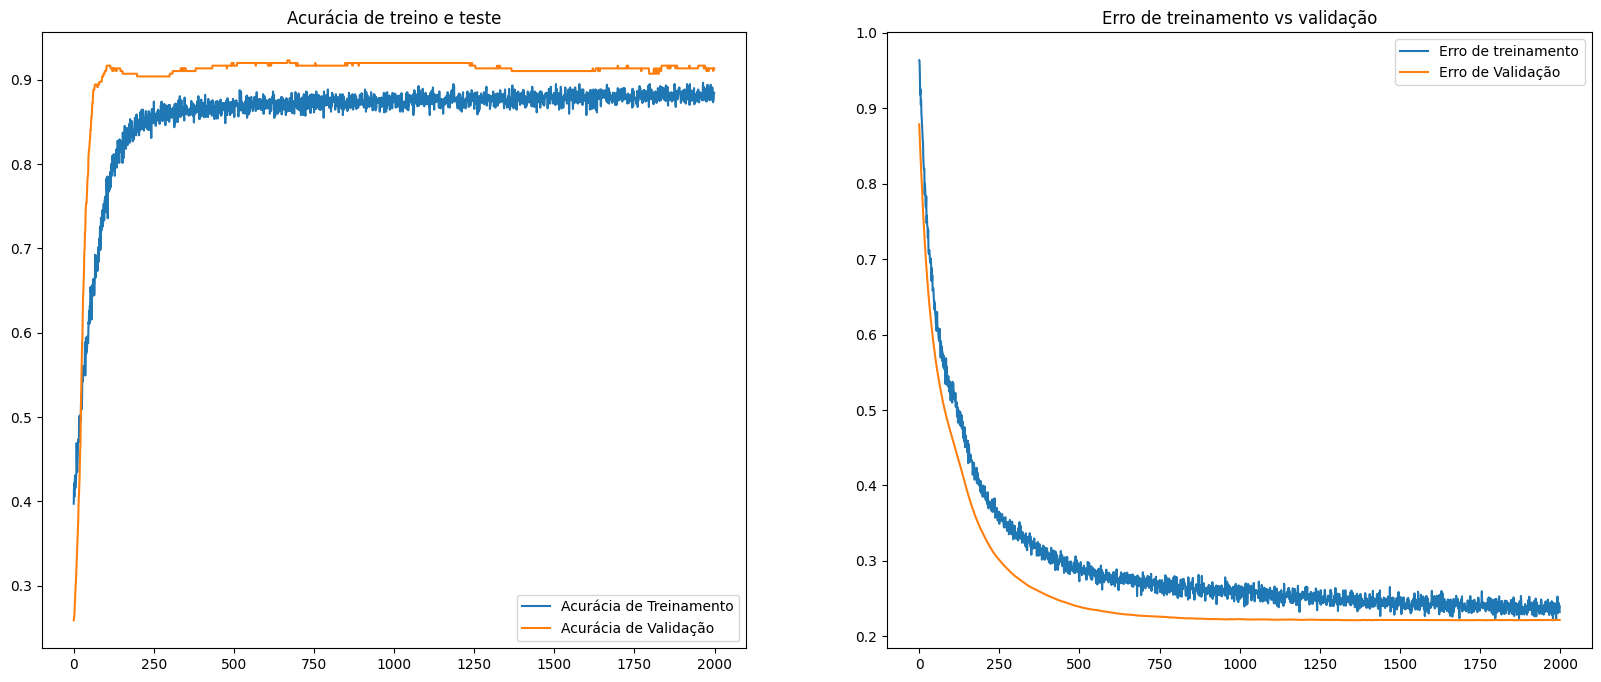

In [656]:
# Visualizando os resultados de treino
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

# Plot Acurácia
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e teste')

# Plot Erro de treinamento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [657]:
# Predictions
y_pred = model.predict(X_test)
y_pred_class = [round(x[0]) for x in y_pred]
y_test_class = y_test

# classification report
class_names = ['Não', 'Sim']

print(classification_report(y_test_class, y_pred_class, target_names=class_names))

10/10 [==============================] - 3s 309ms/step
              precision    recall  f1-score   support

         Não       0.94      0.95      0.95       246
         Sim       0.80      0.79      0.80        67

    accuracy                           0.91       313
   macro avg       0.87      0.87      0.87       313
weighted avg       0.91      0.91      0.91       313



# Exportando o modelo e o scaler

In [659]:
model.save('multilayer-perceptron')

In [684]:
model_training_data_hist.to_csv('model_training_data_hist.csv', index=None)

In [660]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Importando e testando o modelo e o scaler

In [661]:
model_recarregado = load_model('multilayer-perceptron')
scaler_recarregado = joblib.load('scaler.pkl')

In [662]:
teste = df.iloc[0:5]
teste.drop(columns=['INDICADO_BOLSA'], axis=1, inplace=True)
teste = scaler_recarregado.fit_transform(teste)

<ipython-input-662-6ef362041268>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste.drop(columns=['INDICADO_BOLSA'], axis=1, inplace=True)


In [663]:
pred = model_recarregado.predict(teste)
pred

1/1 [==============================] - 0s 70ms/step


array([[3.8874465e-10],
       [7.2716855e-02],
       [2.3325332e-01],
       [2.0014648e-03],
       [3.3936838e-03]], dtype=float32)

In [664]:
pred.flatten().round()

array([0., 0., 0., 0., 0.], dtype=float32)

In [677]:
aluno_bom = pd.DataFrame({
  'IAA': [10.0],
  'IAN': [10.0],
  'IDA': [10.0],
  'IEG': [10.0],
  'INDE': [10.0],
  'IPP': [10.0],
  'IPS': [10.0],
  'IPV': [10.0]
})
aluno_ruim = pd.DataFrame({
  'IAA': [0.0],
  'IAN': [0.0],
  'IDA': [0.0],
  'IEG': [0.0],
  'INDE': [0.0],
  'IPP': [0.0],
  'IPS': [0.0],
  'IPV': [0.0]
})
aluno_ruim2 = pd.DataFrame({
  'IAA': [2.0],
  'IAN': [2.0],
  'IDA': [2.0],
  'IEG': [2.0],
  'INDE': [0.0],
  'IPP': [0.0],
  'IPS': [0.0],
  'IPV': [0.0]
})
aluno_ruim3 = pd.DataFrame({
  'IAA': [5.0],
  'IAN': [8.0],
  'IDA': [6.0],
  'IEG': [0.0],
  'INDE': [2.0],
  'IPP': [0.0],
  'IPS': [1.0],
  'IPV': [0.0]
})
aluno_ruim4 = pd.DataFrame({
  'IAA': [10.0],
  'IAN': [8.0],
  'IDA': [6.0],
  'IEG': [1.0],
  'INDE': [2.0],
  'IPP': [0.0],
  'IPS': [5.0],
  'IPV': [0.0]
})
aluno_mediano1 = pd.DataFrame({
  'IAA': [4.0],
  'IAN': [3.0],
  'IDA': [6.0],
  'IEG': [7.0],
  'INDE': [6.0],
  'IPP': [5.0],
  'IPS': [7.0],
  'IPV': [8.0]
})
aluno_mediano2 = pd.DataFrame({
  'IAA': [8.0],
  'IAN': [8.0],
  'IDA': [9.0],
  'IEG': [5.0],
  'INDE': [4.0],
  'IPP': [5.0],
  'IPS': [7.0],
  'IPV': [7.0]
})
aluno_mediano3 = pd.DataFrame({
  'IAA': [5.0],
  'IAN': [5.0],
  'IDA': [5.0],
  'IEG': [5.0],
  'INDE': [5.0],
  'IPP': [5.0],
  'IPS': [5.0],
  'IPV': [5.0]
})
aluno_mediano4 = pd.DataFrame({
  'IAA': [4.0],
  'IAN': [4.0],
  'IDA': [4.0],
  'IEG': [4.0],
  'INDE': [3.0],
  'IPP': [3.0],
  'IPS': [3.0],
  'IPV': [3.0]
})
# 8.75	6.77	7.5	4.67	7.19	7.37	5.0	6.61
teste = pd.DataFrame(columns=df.columns.difference(['INDICADO_BOLSA']))
teste = pd.concat([teste, aluno_bom, aluno_mediano1, aluno_mediano2, aluno_mediano3, aluno_mediano4, aluno_ruim, aluno_ruim2, aluno_ruim3, aluno_ruim4], ignore_index=True)
teste

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,4.0,3.0,6.0,7.0,6.0,5.0,7.0,8.0
2,8.0,8.0,9.0,5.0,4.0,5.0,7.0,7.0
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
7,5.0,8.0,6.0,0.0,2.0,0.0,1.0,0.0
8,10.0,8.0,6.0,1.0,2.0,0.0,5.0,0.0


In [678]:
pred = model_recarregado.predict(teste)
pred

1/1 [==============================] - 0s 58ms/step


array([[1.0000000e+00],
       [9.9998790e-01],
       [9.9999022e-01],
       [9.9992514e-01],
       [9.9355257e-01],
       [2.4208426e-02],
       [2.1103169e-04],
       [8.2305223e-07],
       [4.4173845e-08]], dtype=float32)

In [679]:
pred.flatten().round()

array([1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)